# Data Analysis - Irradiation of a Fibre Optic Sensor
Measuring humidity in radioactive environments is challenging because, as you might expect, the radiation is massively damaging to sensors. Most commercial humidity sensors are electronic and get wiped out by even a small dose of radiation. 
<!-- This presents a problem for measuring humidity in many environments with high radiation - in space, in nuclear industries and in high energy physics experiments. -->
<!-- (What commercial sensors?
How much radiation kills them??) -->

However, recently a new type of technology has emerged for these cases - fibre optic sensors (FOS). These can survive radiation doses up to the Mega-Gray (MGy) level while still giving a clear signal. Even better, the change in the signal itself can actually be used to measure the radiation dose. Combined with recent breakthroughs in FOS for measuring humidity, these sensors present an exciting potential product with applications in areas such as nuclear industry, high energy physics research, and space travel.
<!-- Link to FOS radiation studies
Link to LPG humidity studies
How much damage would MGy do to a person? -->

This project will take you through analysis of a sensor under irradiation, using real data recorded at the [PS-IRRAD facility](https://ps-irrad.web.cern.ch/ps-irrad/) in CERN, Geneva, SWitzerland.

Project on: [Github](https://github.com/rsamconn/Fibre-optics-demo/tree/notebook-analysis)

## EDA
- 4 datasets in `irrad-demo-data/`:
    - `spectra.txt` - a series of spectra, each containing 20,000 points
    - `hyperion-transmission-spectrum.txt` - a single spectrum of 20,000 points
    - `SEC_data_06-11_09_2023.csv` - data from the IRRAD facility recording the dose rate over time
    - `times.txt` - A series of time values, each corresponding to a spectrum from `spectra.txt`

Let's take a look at the data

In [23]:
# Import the data
import pandas as pd
import numpy as np
# Load the data
data_dir = 'irrad-demo-data/'
spectra = np.loadtxt(data_dir + 'spectra.txt', delimiter=',')
times = np.loadtxt(data_dir + 'times.txt')
baseline = np.loadtxt(data_dir + 'hyperion-transmission-spectrum.txt')
irradiation_df = pd.read_csv(data_dir + 'SEC_data_06-11_09_2023.csv')

In [2]:
irradiation_df.head()

,SEC_ID,TIMESTAMP,SEC_counts
0,SEC_01,11-SEP-23 11.49.12,25376
1,SEC_01,11-SEP-23 11.49.01,25574
2,SEC_01,11-SEP-23 11.48.53,25340
3,SEC_01,11-SEP-23 11.48.48,25320
4,SEC_01,11-SEP-23 11.48.31,25269


In [3]:
data_dict = {
    'spectra.txt': spectra,
    'times.txt': times,
    'hyperion-transmission-spectrum.txt': baseline,
    'SEC_data_06-11_09_2023.csv': irradiation_df
}
for file in data_dict.keys():
    print(f"{file} shape: {np.shape(data_dict[file])}")

spectra.txt shape: (48, 20000)
times.txt shape: (48,)
hyperion-transmission-spectrum.txt shape: (20000,)
SEC_data_06-11_09_2023.csv shape: (31039, 3)


So it looks like we have 48 time steps, and our irradiation data has 3 columns of over 31k rows

# 2. Plotting

Let's take a look at just a single spectrum, at the very first time point.

We'll need to use the wavelength range of the interrogator, the device that reads the spectra, which in our case is a [Hyperion si155](https://lunainc.com/sites/default/files/assets/files/data-sheets/HYPERION%20si155%20Data%20Sheet.pdf) (very expensive!). It has a range of 1460-1620 nm.

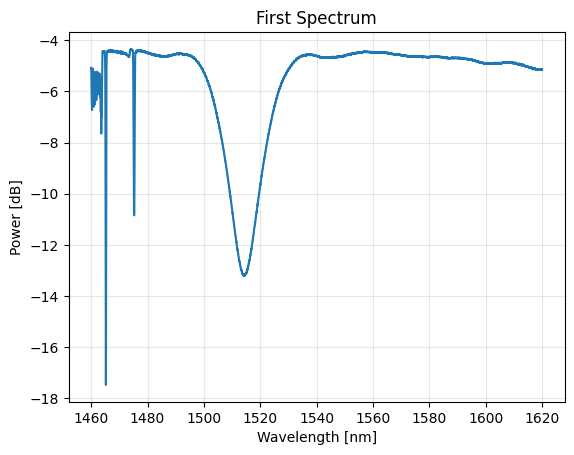

In [7]:
# Create the wavelength range
wavelengths = np.linspace(1460, 1620, spectra.shape[1])

# Plot the first spectrum
import matplotlib.pyplot as plt
plt.plot(wavelengths, spectra[0])
plt.xlabel('Wavelength [nm]')
plt.ylabel('Power [dB]')
plt.title('First Spectrum')
plt.grid(True, alpha=0.3)
plt.show()


We see the spectrum has 3 large dips - two between 1460-1480 nm and one around 1515 nm.
We're only interested in the latter, which corresponds to our LPG sensor.
Let's cut the uninteresting wavelengths out by saving versions of our data that only include wavelengths above 1480 nm.

In [8]:
# Slice the spectra to only include wavelengths above 1480 nm
spectra_LPG_only = spectra[:, 2500:]
wavelengths_LPG_only = wavelengths[2500:]

## 2.2 Plot all the spectra

In [12]:
# Function to plot multiple spectra
import matplotlib.pyplot as plt
def plot_spectra(time_data, spectral_data, wavelength_data, start_idx, end_idx, time_step=30, title="Spectra", cmap='viridis'):
    """Plot wavelength vs intensity for each time point"""
    
    # Slice wavelength array
    wavelength_slice = wavelength_data[start_idx:end_idx]
    
    plt.figure(figsize=(10, 6))

    # If there's only one spectra, just plot normallly
    if type(time_data) is not np.ndarray:
        # If only one time point, plot it directly
        plt.plot(wavelength_slice, spectral_data[start_idx:end_idx], label=f'Time = {time_data:.3f}')
        plt.legend()
    # If there are multiple spectra, plot each with a different color
    else:
        # Set colormap
        colors = plt.cm.jet(np.linspace(0,1, len(time_data)))
        colors = plt.colormaps.get_cmap(cmap)(np.linspace(0, 1, len(time_data)))
        # Loop over each time point and plot
        for i in range(0, len(time_data), time_step):
            # print(f'Number of time steps {len(range(0, len(time_data), time_step))}')
            if len(range(0, len(time_data), time_step)) <= 20:
                # Use time values in legend if 15 or less
                plt.plot(wavelength_slice, spectral_data[i][start_idx:end_idx], color=colors[i], label=f'Time = {time_data[i]:.2f}')
            else:
                # No legend if more than 15 time points
                plt.plot(wavelength_slice, spectral_data[i][start_idx:end_idx], color=colors[i])
        
    plt.xlabel('Wavelength [nm]')
    plt.ylabel('Power [dB]')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

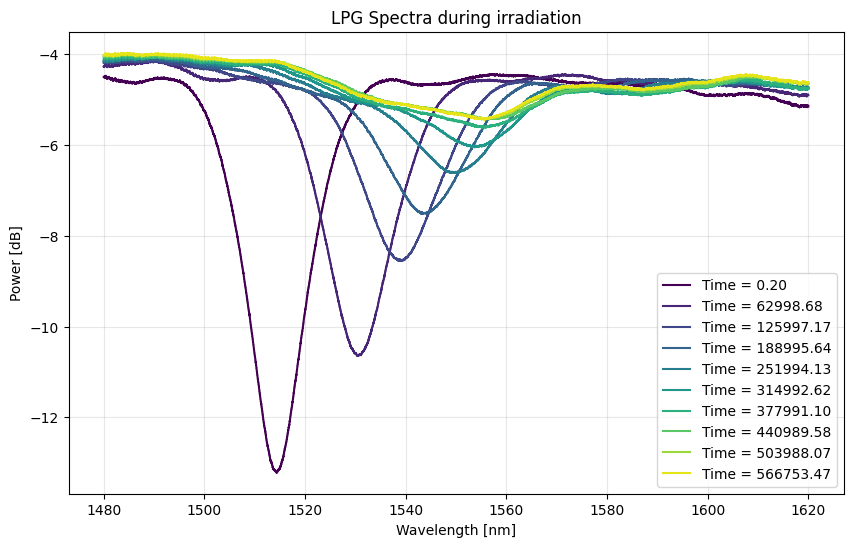

In [13]:
# Plot all the spectra
plot_spectra(times, spectra_LPG_only, wavelengths_LPG_only, start_idx=0, end_idx=-1, time_step=5, title='LPG Spectra during irradiation')

That looks pretty and we can immediately see several effects on the spectrum as it gets irradiated:
- The dip is getting shallower - the power depth of the dip is decreasing.
- The dip moves to the right - the spectrum wavelength is redshifted as it gets irradiated.

However, it's a bit difficult to see the dip of the LPG spectra in the final time steps. Let's *rebaseline* the spectra - subtract the standard transmission spectrum that occurs when there's no sensor in the fibre.

In [15]:
# Subtract the baseline from the spectra
rebaselined_spectra = spectra_LPG_only - baseline[2500:]

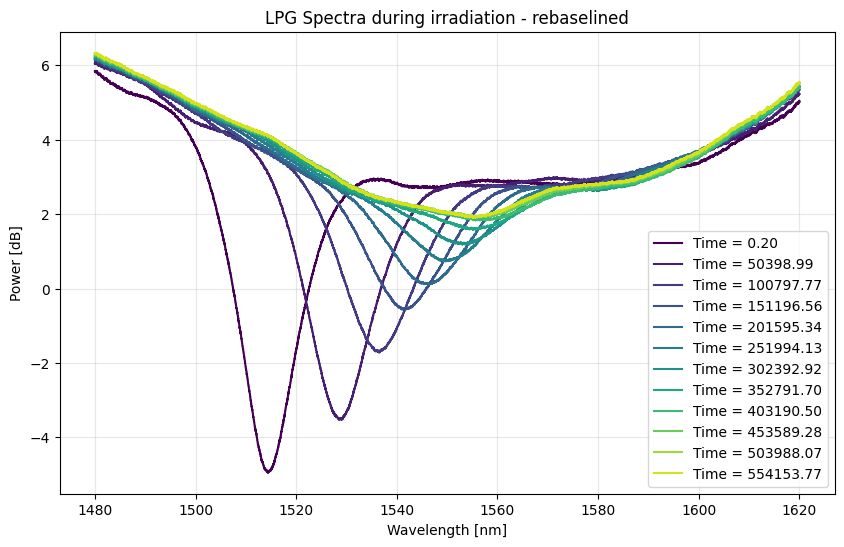

In [17]:
plot_spectra(times, rebaselined_spectra, wavelengths_LPG_only, start_idx=0, end_idx=-1, time_step=4, title='LPG Spectra during irradiation - rebaselined')

That looks better - now we can see the LPG dip more clearly.

All very well but what can we do with this? The answer is in the last step - we track the redshift.

## 3. Wavelength Shift
Fibre optic sensors can measure changes in temperature, strain, relative humidity and much more because these shift the dip in their spectrum.

If we know how much the dip shifts, we can calibrate this to a reference and sensor and voila - we can measure that variable.

### 3.1 Extract the dip minima
There are many complex methods to tell how much a dip/ peak has shifted but we'll use a simple one here - extracting the minimum of the spectrum.

In [19]:
# Extract the spectra minima
def extract_spectra_minima(spectral_data, wavelength_data):
    """Extract the minima of each spectrum"""
    intensity_minima = []
    wavelength_minima = []
    count = 0
    for spectrum in spectral_data:
        count += 1
        min_index = np.argmin(spectrum)
        # print(f"Processing spectrum with shape {spectrum.shape} and found minimum at index {min_index} with wavelength {wavelength_data[min_index]}")
        intensity_minima.append(spectrum[min_index])
        wavelength_minima.append(wavelength_data[min_index])
    print(count)
    return wavelength_minima, intensity_minima

In [20]:
rebaselined_minima = extract_spectra_minima(rebaselined_spectra, wavelengths_LPG_only)


48


Text(0, 0.5, 'Wavelength shift [nm]')

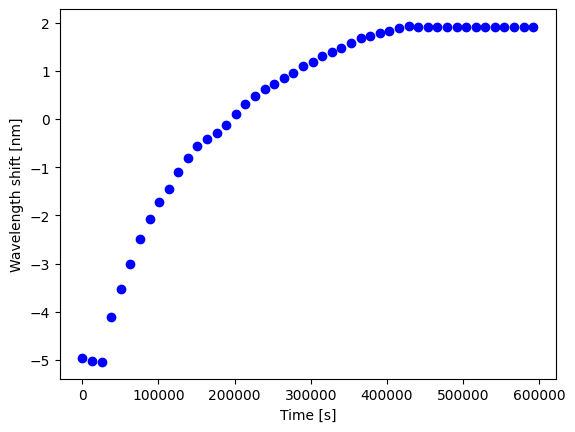

In [21]:
first_minimum = rebaselined_minima[0][0]
wavlength_shift = rebaselined_minima[0] - first_minimum
plt.scatter(times, rebaselined_minima[1], c='blue', label='Rebaselined Spectrum at Wavelength 1460 nm')
plt.xlabel('Time [s]')
plt.ylabel('Wavelength shift [nm]')

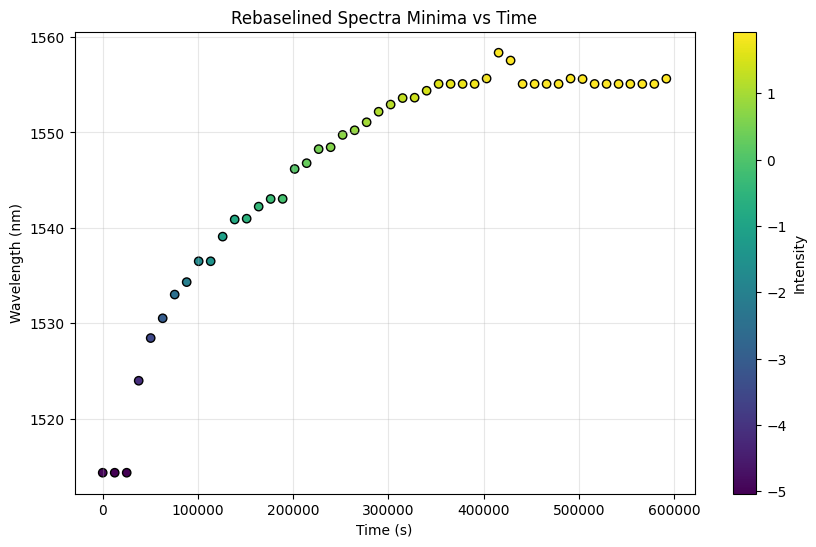

In [22]:
# Plot the minima vs time
def plot_minima_vs_time(minima, time_data, title="Spectra Minima vs Time"):
    """Plot the minima of each spectrum against time"""
    # wavelengths, intensities = zip(*minima)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(time_data, minima[0], c=minima[1], cmap='viridis', edgecolor='k')
    plt.colorbar(label='Intensity')
    plt.xlabel('Time (s)')
    plt.ylabel('Wavelength (nm)')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.show()
plot_minima_vs_time(rebaselined_minima, times, title="Rebaselined Spectra Minima vs Time")

## 4. Adding radiation dose
Now let's include the radiation dose so we can see exactly what the wavelength shift corresponds to what dose. To do this we'll need our irradiation data.

In [24]:
# Explore irradiation data
irradiation_df.value_counts()

SEC_ID  TIMESTAMP           SEC_counts
SEC_01  08-SEP-23 22.55.29  0             2
        10-SEP-23 14.13.47  0             2
        10-SEP-23 14.15.11  0             2
        06-SEP-23 22.34.30  26351         1
        10-SEP-23 04.07.34  25794         1
                                         ..
        08-SEP-23 15.25.41  26332         1
        08-SEP-23 15.25.29  26450         1
        08-SEP-23 15.25.12  26257         1
        08-SEP-23 15.25.00  26952         1
        11-SEP-23 11.49.12  25376         1
Name: count, Length: 31036, dtype: int64

We see the first column, SEC_ID, only has one value repeated so we can drop that. The TIMESTAMP column contains date times, while the SEC_counts columns contains a number proportional to the radiation dose at that time.

First, let's convert the TIMESTAMP column to datetimes so that we can create another column going from t=0 to the end of the irradiation.

In [25]:
# Function to convert datetime strings
from datetime import datetime

def convert_datetime_string(date_str):
    """
    Convert datetime string in format "11-SEP-23 11.49.12" to datetime object
    
    Args:
        date_str (str): Date string in format "DD-MMM-YY HH.MM.SS"
    
    Returns:
        datetime: Converted datetime object
    """
    return datetime.strptime(date_str, "%d-%b-%y %H.%M.%S")

In [ ]:
#

In [26]:
# Convert TIMESTAMP column to datetime objects
irradiation_df['datetime'] = irradiation_df['TIMESTAMP'].apply(convert_datetime_string)

# Calculate time difference in seconds from the first row
first_time = irradiation_df['datetime'].iloc[0]
irradiation_df['time_seconds'] = (irradiation_df['datetime'] - first_time).dt.total_seconds()

# Show the first few rows with our new columns
print("DataFrame with new datetime columns:")
print(irradiation_df.head())

DataFrame with new datetime columns:
   SEC_ID           TIMESTAMP  SEC_counts            datetime  time_seconds
0  SEC_01  11-SEP-23 11.49.12       25376 2023-09-11 11:49:12           0.0
1  SEC_01  11-SEP-23 11.49.01       25574 2023-09-11 11:49:01         -11.0
2  SEC_01  11-SEP-23 11.48.53       25340 2023-09-11 11:48:53         -19.0
3  SEC_01  11-SEP-23 11.48.48       25320 2023-09-11 11:48:48         -24.0
4  SEC_01  11-SEP-23 11.48.31       25269 2023-09-11 11:48:31         -41.0


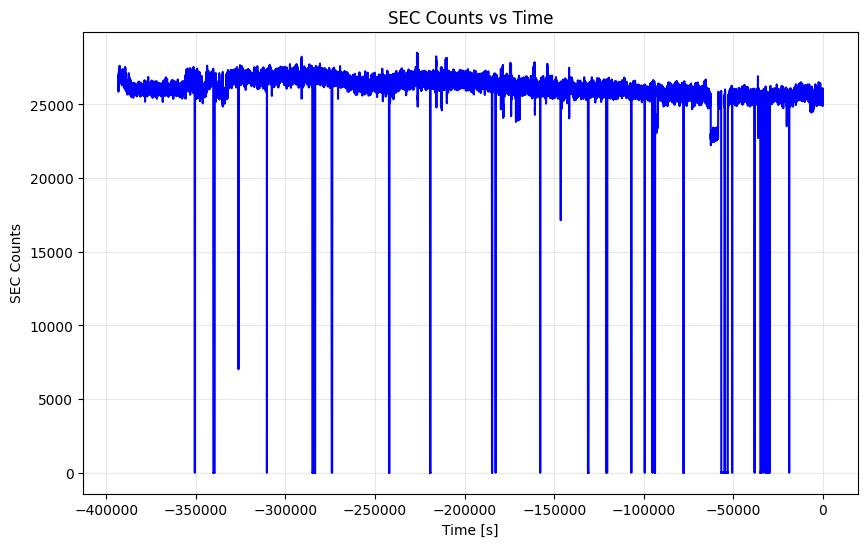

In [28]:
# Plot SEC_counts vs time
plt.figure(figsize=(10, 6))
plt.plot(irradiation_df['time_seconds'], irradiation_df['SEC_counts'], linestyle='-', color='blue')
plt.xlabel('Time [s]')
plt.ylabel('SEC Counts')
plt.title('SEC Counts vs Time')
plt.grid(True, alpha=0.3)
plt.show()